# 42186 - Model-based Machine Learning Project
## Group 12

------

### This notebook seek to analyse and model outpatient activity and visit duration at Rigshospitalet.


First the following packages, scripts and data has to be loaded

In [77]:
# Standard libraries
import os
import pickle

# Data manipulation
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt  # (duplicate removed)

# Machine Learning
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# PyTorch
import torch

# Pyro
import pyro
import pyro.poutine as poutine
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoNormal
from pyro.infer.autoguide import AutoNormal  # (already imported above from contrib)

# Custom modules
from utils import split_patient_level
from Preprocess_df import standardize_df, standardize_tensor
from Preprocess_df import reverse_standardize_tensor


# RUN THE SCRIPT Clean_data.py ONE TIME
# load data CaseRigshospitalet_summed.parquet
df = pd.read_parquet('data/CaseRigshospitalet_summed.parquet')

These notebooks will take you thourgh some models, which seek to predict the contact duration in hours. 

First we will try out with a simple probabilistic graphical model, namely the Heteroscedatic regression model. Thereafter wee seek to expand the model by including demographic data of a patient and create a Mixture model...

Finale wee want to compare the findings to a Multiple-channel latent Dirichlet allocation.

In this notebook we would like to take you through the following

### Content
* Visualization of the data
* Preprocessing the dataset
* Heteroscedatic regression model using diagnostic
* Heteroscedatic regression model using diagnostic and demographic data of a patient
* Simple regression model using diagnostic and demographic data of a patient

## Visualization of the data

First we will have a look at the data that we are working with, run the following code and have a look at some of the attributes (it is in danish).


In [121]:
print(df.head())

  Patient ID Aktionsdiagnosekode  totalDiagnoseKontaktVarighed  \
0       Z100               DM059                          1.65   
1   Z1000004              DG930A                          0.32   
2   Z1000010              DM511D                          6.98   
3   Z1000010               DM549                          1.43   
4   Z1000018               DQ253                          3.85   

   antalKontakter  antalDiagnoser      alder  gender civilStand  \
0               2               1       51.0  Kvinde       Gift   
1               1               1       32.0    Mand       Gift   
2               5               2       45.2    Mand       Gift   
3               1               2       45.0    Mand       Gift   
4               3               1  44.666667    Mand      Ugift   

   distanceToHospitalKM patientKommune  \
0              0.974812      København   
1             18.368636         Furesø   
2              2.963563      København   
3              2.963563      Køb

Since we are working with predicting time we take look an standadize, look at the transformation below.

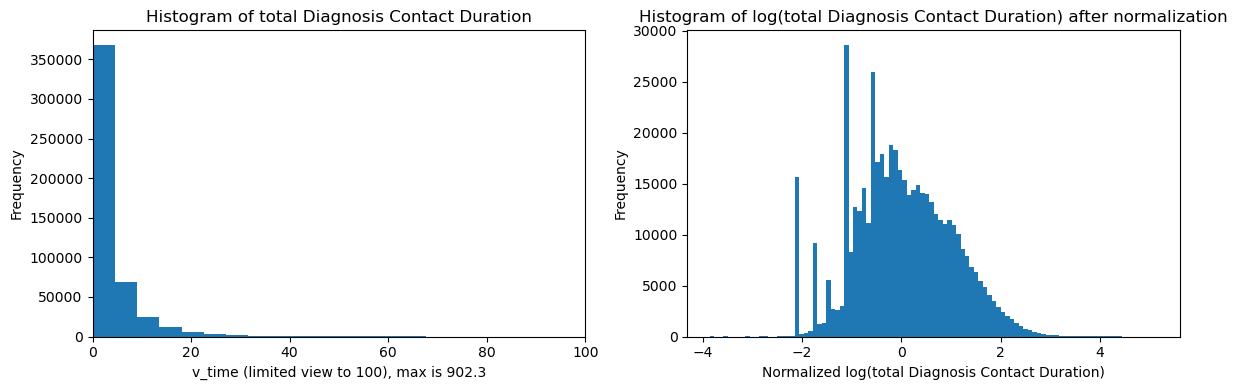

In [78]:
v_time = df["totalDiagnoseKontaktVarighed"]
fig, ax = plt.subplots(1,2, figsize=(12, 4))
ax[0].hist(v_time, bins=200)
ax[0].set_title("Histogram of total Diagnosis Contact Duration")
ax[0].set_xlabel(f"v_time (limited view to 100), max is {np.max(v_time):.1f}")
ax[0].set_ylabel("Frequency")
ax[0].set_xlim(0, 100)

v_time_log = np.log(v_time)

#standize
v_time_log = (v_time_log-np.mean(v_time_log))/np.std(v_time_log)
ax[1].hist(v_time_log, bins=100)
ax[1].set_title("Histogram of log(total Diagnosis Contact Duration) after normalization")
ax[1].set_xlabel("Normalized log(total Diagnosis Contact Duration)")
ax[1].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

## Preprocessing the dataset

Lets split the data in train and testset and standadize it

In [79]:
# Split the data into training and test sets
(x_emb_train, d_demo_train, v_time_train, a_count_train), (x_emb_test, d_demo_test, v_time_test, a_count_test) = split_patient_level(df, total_samples=len(df))

# Standardize the embeddings and demographic data
x_emb_train_pca, x_emb_test_pca, d_demo_train, d_demo_test = standardize_df(x_emb_train, x_emb_test, d_demo_train, d_demo_test)
# Standardize the log v_time_train
v_time_train, mean_v_time_train, std_v_time_train = standardize_tensor(torch.log(v_time_train))

Demographic columns: ['alder', 'distanceToHospitalKM', 'gender_Kvinde', 'gender_Mand', 'gender_Ukendt', 'civilStand_Fraskilt', 'civilStand_Gift', 'civilStand_Ugift']


## Heteroscedatic regression model using diagnostic

The dataset have an attribute called 'Action diagnostic code', which we have made an Bert embedding on.

The Heteroscedatic regression model take as input a BERT embedding of the observed variable diagnosis description, $\bm{x}=BERT(diagnosis)$, where $x \in \mathbb{R}^K$. 

The Generative Process
1) Draw $\beta_k \sim \mathcal{N}(0,1)$, for $k \in \{1,2,\dots, K\}$

2) Draw $\eta_k \sim \mathcal{N}(0,1)$, for $k \in \{1,2,\dots, K\}$

3) For each patient, $p$, in $P$

    a) Draw $v_p \sim \text{Normal}(\beta^T\mathbb{x}_p, \eta^T \mathbb{x}_p)$


Define test and train for all the models

In [81]:
# add ones as the intercept term
ones_train = torch.ones((x_emb_train_pca.shape[0], 1), dtype=torch.float32)
X_train = torch.cat((ones_train, x_emb_train_pca), dim=1)

ones_test = torch.ones((x_emb_test_pca.shape[0], 1), dtype=torch.float32)
X_test = torch.cat((ones_test, x_emb_test_pca), dim=1)

v_train = v_time_train
v_test = v_time_test

### Model and ELBO optimization

In [103]:
# ==== Data ====
X = X_train
y = v_train

# ==== Model ====
def heteroscedastic_regression(data, targets=None):
    P, D = data.shape

    # Prior on beta and eta
    beta = pyro.sample("beta", dist.Normal(0., 1).expand([D]).to_event(1))
    eta = pyro.sample("eta", dist.Normal(0., 1).expand([D]).to_event(1))

    with pyro.plate("data", P):
        loc = data @ beta
        scale = torch.nn.functional.softplus(data @ eta)
        pyro.sample("v", dist.Normal(loc, scale), obs=targets)

# ==== Guide ====
guide = AutoNormal(heteroscedastic_regression)

# ==== Optimizer ====
pyro.clear_param_store()
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# ==== Inference ====
elbo = Trace_ELBO(num_particles=3)
svi = SVI(heteroscedastic_regression, guide, optimizer, loss=elbo)

n_steps = 1500
loss_curve = np.zeros(n_steps)
for step in range(n_steps):
    loss = svi.step(X, y)
    loss_curve[step] = loss
    if step % 500 == 0:
        print(f"[{step}] ELBO: {loss:.2f}")

# ==== Posterior Mean Estimates ====
posterior = guide(X)
beta_mean_d = posterior["beta"]
eta_mean_d = posterior["eta"]

print("\nPosterior mean of beta (first 5 dims):", beta_mean_d[:5])
print("Posterior mean of eta (first 5 dims):", eta_mean_d[:5])


[0] ELBO: 164378132.01
[500] ELBO: 510310.38
[1000] ELBO: 486108.54

Posterior mean of beta (first 5 dims): tensor([ 0.0022, -0.0206,  0.0283,  0.0147,  0.0284], grad_fn=<SliceBackward0>)
Posterior mean of eta (first 5 dims): tensor([ 0.2720, -0.0175,  0.0053, -0.0170,  0.0236], grad_fn=<SliceBackward0>)


We will have a closer look at the Elbo, run the following code to see the loss starting from step 500

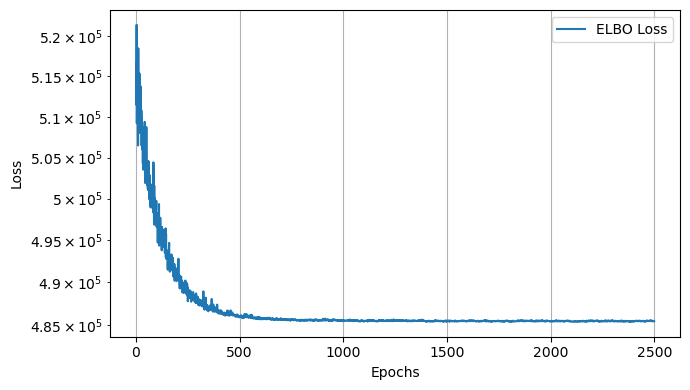

In [102]:
# plot loss curve
plt.figure(figsize=(7, 4))
plt.plot(loss_curve[500:], label='ELBO Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.tight_layout()


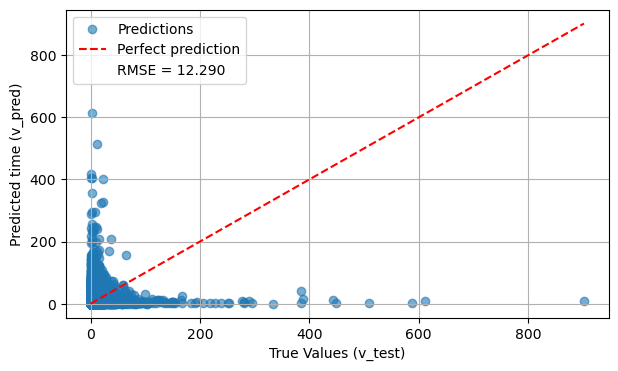

In [94]:
# New predictions
y_pred_log = dist.Normal(X_test @ beta_mean_d, torch.nn.functional.softplus(X_test @ eta_mean_d)).sample()

# Convert predictions and true values back to original scale
y_pred_np = np.exp(reverse_standardize_tensor(y_pred_log, mean_v_time_train, std_v_time_train).cpu().numpy())
v_test_np = v_time_test.cpu().numpy()

# Compute RMSE
rmse = np.sqrt(mean_squared_error(v_test_np, y_pred_np))

# Plot
plt.figure(figsize=(7, 4))
plt.scatter(v_test_np, y_pred_np, alpha=0.6, label="Predictions")
plt.plot([v_test_np.min(), v_test_np.max()],
         [v_test_np.min(), v_test_np.max()],
         'r--', label="Perfect prediction")

# Add dummy plot for RMSE
plt.plot([], [], ' ', label=f"RMSE = {rmse:.3f}")

plt.xlabel("True Values (v_true)")
plt.ylabel("Predicted time (v_pred)")
plt.legend()
plt.grid(True)
plt.show()


## Heteroscedatic regression model using diagnostic and demographic data of a patient

Next is the same Heteroscedatic regression model but aslo using the demographic data of the patent. So the input to the model is a BERT embedding as before, as weel as the demographic data $d$, so now $x \in \mathbb{R}^{K+len(d)}$.

In [66]:
X_train_full = torch.cat((X_train, d_demo_train), dim=1)
X_test_full = torch.cat((X_test, d_demo_test), dim=1)

### Model and ELBO optimization

In [41]:
# ==== Data ====
X = X_train_full
y = v_time_train

# ==== Model ====
def heteroscedastic_regression(data, targets=None):
    P, D = data.shape

    # Prior on beta and eta
    beta = pyro.sample("beta", dist.Normal(0., 1).expand([D]).to_event(1))
    eta = pyro.sample("eta", dist.Normal(0., 1).expand([D]).to_event(1))

    with pyro.plate("data", P):
        loc = data @ beta
        scale = torch.nn.functional.softplus(data @ eta) + 1e-8

        pyro.sample("v", dist.Normal(loc, scale), obs=targets)

# ==== Guide ====
guide = AutoNormal(heteroscedastic_regression)

# ==== Optimizer ====
pyro.clear_param_store()
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# ==== Inference ====
elbo = Trace_ELBO(num_particles=3)
svi = SVI(heteroscedastic_regression, guide, optimizer, loss=elbo)

n_steps = 5000
loss_curve = np.zeros(n_steps)
for step in range(n_steps):
    loss = svi.step(X, y)
    loss_curve[step] = loss
    if step % 500 == 0:
        print(f"[{step}] ELBO: {loss:.2f}")

# ==== Posterior Mean Estimates ====
posterior = guide(X)
beta_mean_PP = posterior["beta"]
eta_mean_PP = posterior["eta"]

print("\nPosterior mean of beta (first 5 dims):", beta_mean_PP[:5])
print("Posterior mean of eta (first 5 dims):", eta_mean_PP[:5])


[0] ELBO: 3686392675965702521225216.00
[500] ELBO: 714895.76
[1000] ELBO: 194100933543142064128.00
[1500] ELBO: 492255.07
[2000] ELBO: 490282.50
[2500] ELBO: 493173.67
[3000] ELBO: 492346.34
[3500] ELBO: 490236.78
[4000] ELBO: 4665339895213633536.00
[4500] ELBO: 491957.30

Posterior mean of beta (first 5 dims): tensor([-0.0969, -0.0217,  0.0335,  0.0196,  0.0117], grad_fn=<SliceBackward0>)
Posterior mean of eta (first 5 dims): tensor([-0.0018, -0.0084, -0.0018, -0.0214,  0.0435], grad_fn=<SliceBackward0>)


We will have a closer look at the Elbo, run the following code to see the loss starting from step 1000

Text(0, 0.5, 'ELBO Loss')

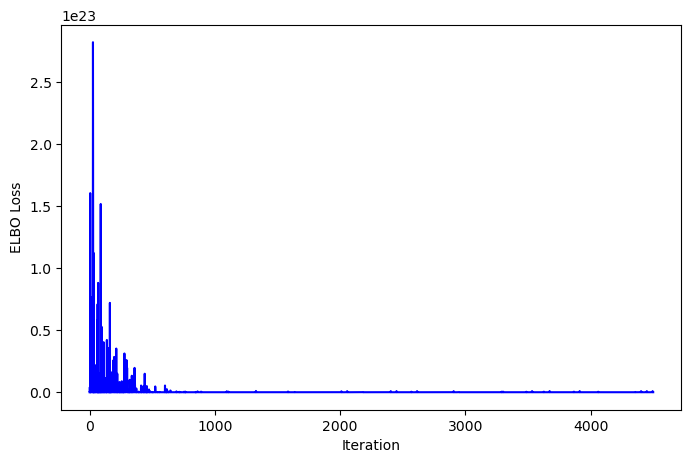

In [43]:
# plot the loss curve
plt.figure(figsize=(8, 5))
plt.plot(loss_curve[500:], label='ELBO Loss', color='blue')
plt.xlabel('Iteration')
plt.ylabel('ELBO Loss')

/var/folders/w4/drmx799s2w14d7q5v4w2_y_r0000gn/T/ipykernel_5919/3079812417.py:5: RuntimeWarning: overflow encountered in exp
  y_pred_np = np.exp(reverse_standardize_tensor(y_pred_log, mean_v_time_train, std_v_time_train).cpu().numpy())


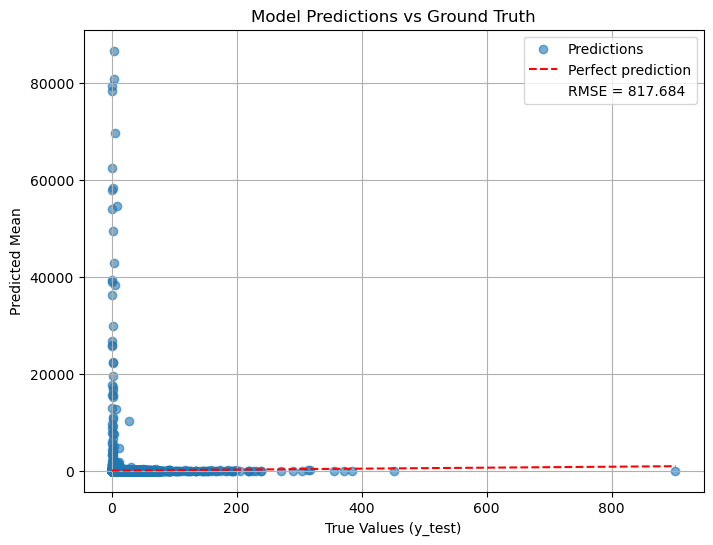

In [46]:
# New predictions
y_pred_log = dist.Normal(X_test_full @ beta_mean_PP, torch.nn.functional.softplus(X_test_full @ eta_mean_PP)+ 1e-8).sample()

# Convert predictions and true values back to original scale
y_pred_np = np.exp(reverse_standardize_tensor(y_pred_log, mean_v_time_train, std_v_time_train).cpu().numpy())
v_test_np = v_time_test.cpu().numpy()

# Define a max value threshold (e.g., 1e6) to clip out extreme values
threshold = 1e5

# Create a valid mask
mask = np.isfinite(y_pred_np) & (y_pred_np < threshold) & (v_test_np < threshold)

# Apply the mask
y_pred_clean = y_pred_np[mask]
v_test_clean = v_test_np[mask]


# Compute RMSE
rmse = np.sqrt(mean_squared_error(v_test_clean, y_pred_clean))

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(v_test_clean, y_pred_clean, alpha=0.6, label="Predictions")
plt.plot([v_test_clean.min(), v_test_clean.max()],
         [v_test_clean.min(), v_test_clean.max()],
         'r--', label="Perfect prediction")

# Add dummy plot for RMSE
plt.plot([], [], ' ', label=f"RMSE = {rmse:.3f}")

plt.xlabel("True Values (v_true)")
plt.ylabel("Predicted time (v_pred)")
plt.title("Model Predictions vs Ground Truth")
plt.legend()
plt.grid(True)
plt.show()

## Simple regression model using diagnostic and demographic data of a patient

The Generative Process
1) Draw $\beta_k \sim \mathcal{N}(0,1)$, for $k \in \{1,2,\dots, K\}$

2) Draw $\eta_k \sim \mathcal{N}(0,1)$, for $k \in \{1,2,\dots, K\}$

3) For each patient, $p$, in $P$

    a) Draw $v_p \sim \text{Normal}(\beta^T\mathbb{x}_p, \sigma^2)$


### Model and ELBO optimization

In [67]:
# ==== Data ====
X = X_train
y = v_time_train

# ==== Model ====
def log_normal(data, targets=None):
    P, D = data.shape

    # Prior over beta
    beta = pyro.sample("beta", dist.Normal(0., 1.).expand([D]).to_event(1))

    with pyro.plate("data", P):
        loc = data @ beta
        sigma = pyro.sample("sigma", dist.HalfCauchy(1.0))
        pyro.sample("obs", dist.Normal(loc, sigma), obs=targets)

# ==== Guide ====
guide = AutoNormal(log_normal)

# ==== Optimizer ====
pyro.clear_param_store()
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# ==== Inference ====
elbo = Trace_ELBO(num_particles=3)
svi = SVI(log_normal, guide, optimizer, loss=elbo)

n_steps = 3000
loss_curve = np.zeros(n_steps)
for step in range(n_steps):
    loss = svi.step(X, y)
    loss_curve[step] = loss
    if step % 500 == 0:
        print(f"[{step}] ELBO: {loss:.2f}")

# ==== Posterior Mean Estimate ====
posterior = guide(X)
beta_mean_PP_I = posterior["beta"]

print("\nPosterior mean of beta (first 5 dims):", beta_mean_PP_I[:5])

[0] ELBO: 1880406.58
[500] ELBO: 685933.18
[1000] ELBO: 633473.57
[1500] ELBO: 632217.18
[2000] ELBO: 629695.05
[2500] ELBO: 630608.29

Posterior mean of beta (first 5 dims): tensor([-0.0541, -0.0278,  0.0311,  0.0249,  0.0205], grad_fn=<SliceBackward0>)


We will have a closer look at the Elbo, run the following code to see the loss starting from step 500

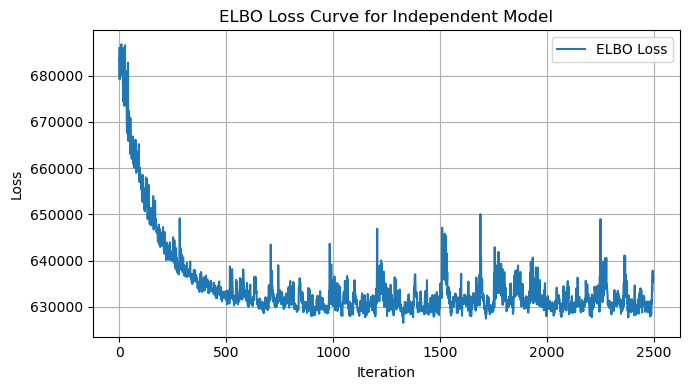

In [68]:
# plot loss curve
plt.figure(figsize=(7, 4))
plt.plot(loss_curve[500:], label='ELBO Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('ELBO Loss Curve for Independent Model')
plt.legend()
plt.grid()
plt.tight_layout()

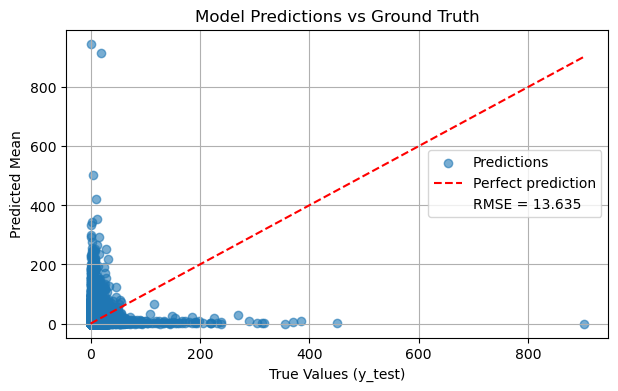

In [74]:
# New predictions
y_pred_log = dist.Normal(X_test @ beta_mean_PP_I, torch.tensor(1.0)).sample()

# Convert predictions and true values back to original scale
y_pred_np = np.exp(reverse_standardize_tensor(y_pred_log, mean_v_time_train, std_v_time_train).cpu().numpy())
v_test_np = v_time_test.cpu().numpy()

# Compute RMSE
rmse = np.sqrt(mean_squared_error(v_test_np, y_pred_np))

# Plot
plt.figure(figsize=(7, 4))
plt.scatter(v_test_np, y_pred_clean, alpha=0.6, label="Predictions")
plt.plot([v_test_np.min(), v_test_np.max()],
         [v_test_np.min(), v_test_np.max()],
         'r--', label="Perfect prediction")

# Add dummy plot for RMSE
plt.plot([], [], ' ', label=f"RMSE = {rmse:.3f}")

plt.xlabel("True Values (v_true)")
plt.ylabel("Predicted time (v_pred)")
plt.title("Model Predictions vs Ground Truth")
plt.legend()
plt.grid(True)
plt.show()
